In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from npDoseResponse import DRCurve
from npDoseResponse import DRDerivCurve, NeurNet, RADRDerivBC, IPWDRDerivBC, DRDRDerivBC
from sklearn.neural_network import MLPRegressor

import warnings
warnings.filterwarnings('ignore')

## Example 3:  RA, IPW, DR Estimations of Dose-Response Curve and its Derivative Under Positivity

We generate i.i.d. data $\{(Y_i,T_i,\mathbf{S}_i)\}_{i=1}^n$ from the following data-generating model
\begin{align*}
&Y=1.2\,T+T^2 + TS_1+1.2\,\mathbf{\xi}^T\mathbf{S} +\epsilon\cdot \sqrt{0.5+F_{\mathcal{N}(0,1)}(S_1)}, \quad \epsilon\sim \mathcal{N}(0,1),\\ 
&T= F_{\mathcal{N}(0,1)}\left(3\mathbf{\xi}^T\mathbf{S}\right) - 0.5 + 0.75E, \quad  \mathbf{S}=(S_1,...,S_d)^T \sim \mathcal{N}_d\left(\mathbf{0}, \Sigma\right), \quad E\sim \mathcal{N}(0,1),
\end{align*}
where $F_{\mathcal{N}(0,1)}$ is the CDF of $\mathcal{N}\left(0, 1\right)$, $\mathbf{\xi}=(\xi_1,...,\xi_d)^T \in \mathbb{R}^d$ has its entry $\xi_j=\frac{1}{j^2}$ for $j=1,...,d$ as well as $\Sigma_{ii}=1$, $\Sigma_{ij}=0.5$ when $|i-j|=1$, and $\Sigma_{ij}=0$ when $|i-j|>1$ for $i,j=1,...,d$. Here, $n=2000$ and $d=20$. The dose-response curve is thus given by $m(t)= 1.2t+t^2$, and our parameter of interest here is the derivative effect curve $\theta(t)=1.2+2t$.

In [2]:
rho = 0.5  # correlation between adjacent Xs
d = 20   # Dimension of the confounding variables
n = 2000

Sigma = np.zeros((d,d)) + np.eye(d)
for i in range(d):
    for j in range(i+1, d):
        if (j < i+2) or (j > i+d-2):
            Sigma[i,j] = rho
            Sigma[j,i] = rho
sig = 1

np.random.seed(123)
# Data generating process
X_sim = np.random.multivariate_normal(mean=np.zeros(d), cov=Sigma, size=n)
nu = np.random.randn(n)
eps = np.random.randn(n)

theta = 1/(np.linspace(1, d, d)**2)

T_sim = scipy.stats.norm.cdf(3*np.dot(X_sim, theta)) + 3*nu/4 - 1/2
Y_sim = 1.2*T_sim + T_sim**2 + T_sim*X_sim[:,0] + 1.2*np.dot(X_sim, theta) + eps*np.sqrt(0.5+ scipy.stats.norm.cdf(X_sim[:,0]))
X_dat = np.column_stack([T_sim, X_sim])

t_qry = np.linspace(-2, 2, 41)

# Choice of the bandwidth parameter
h = 4*np.std(T_sim)*n**(-1/5)

In [3]:
# RA estimator
reg_mod = MLPRegressor(hidden_layer_sizes=(10,), activation='relu', learning_rate='adaptive', 
                       learning_rate_init=0.1, random_state=1, max_iter=200)
m_est_ra5 = DRCurve(Y=Y_sim, X=X_dat, t_eval=t_qry, est="RA", mu=reg_mod, 
                    L=5, h=None, kern="epanechnikov", print_bw=False)

In [4]:
# IPW estimator
regr_nn2 = MLPRegressor(hidden_layer_sizes=(20,), activation='relu', learning_rate='adaptive', 
                        learning_rate_init=0.1, random_state=1, max_iter=200)
m_est_ipw5 = DRCurve(Y=Y_sim, X=X_dat, t_eval=t_qry, est="IPW", mu=None, 
                     condTS_type='kde', condTS_mod=regr_nn2, tau=0.001, L=5, h=h, 
                     kern="epanechnikov", h_cond=None, self_norm=True, print_bw=True)

The current bandwidth for the IPW estimator is 0.7621626742251334.

The current bandwidth for KDE is 0.2766293896223984.

The current bandwidth for KDE is 0.28090411097493984.

The current bandwidth for KDE is 0.2679859487988173.

The current bandwidth for KDE is 0.27450789972131157.

The current bandwidth for KDE is 0.2771505691728006.



In [5]:
m_est_dr5, sd_est_dr5 = DRCurve(Y=Y_sim, X=X_dat, t_eval=t_qry, est="DR", mu=reg_mod, 
                                condTS_type='kde', condTS_mod=regr_nn2, tau=0.001, L=5, 
                                h=h, kern="epanechnikov", h_cond=None, self_norm=True, print_bw=True)

The current bandwidth for the DR estimator is 0.7621626742251334.

The current bandwidth for KDE is 0.2766293896223984.

The current bandwidth for KDE is 0.28090411097493984.

The current bandwidth for KDE is 0.2679859487988173.

The current bandwidth for KDE is 0.27450789972131157.

The current bandwidth for KDE is 0.2771505691728006.



In [ ]:
# RA estimator of \theta(t)
theta_ra5 = DRDerivCurve(Y=Y_sim, X=X_dat, t_eval=t_qry, est="RA", beta_mod=NeurNet, 
                         n_iter=1000, lr=0.01, L=5, print_bw=False)

In [7]:
# IPW estimator of \theta(t)
theta_ipw5 = DRDerivCurve(Y=Y_sim, X=X_dat, t_eval=t_qry, est="IPW", beta_mod=None, 
                          condTS_type='kde', condTS_mod=regr_nn2, tau=0.001, L=5, 
                          h=h, kern="epanechnikov", h_cond=None, self_norm=True, print_bw=True)

The current bandwidth for the IPW estimator is 0.7621626742251334.

The current bandwidth for KDE is 0.2766293896223984.

The current bandwidth for KDE is 0.28090411097493984.

The current bandwidth for KDE is 0.2679859487988173.

The current bandwidth for KDE is 0.27450789972131157.

The current bandwidth for KDE is 0.2771505691728006.



In [ ]:
# DR estimator of \theta(t)
theta_dr5, theta_sd5 = DRDerivCurve(Y=Y_sim, X=X_dat, t_eval=t_qry, est="DR", beta_mod=NeurNet, 
                                    n_iter=1000, lr=0.01, condTS_type='kde', condTS_mod=regr_nn2, tau=0.001, 
                                    L=5, h=h, kern="epanechnikov", h_cond=None, self_norm=True, print_bw=True)

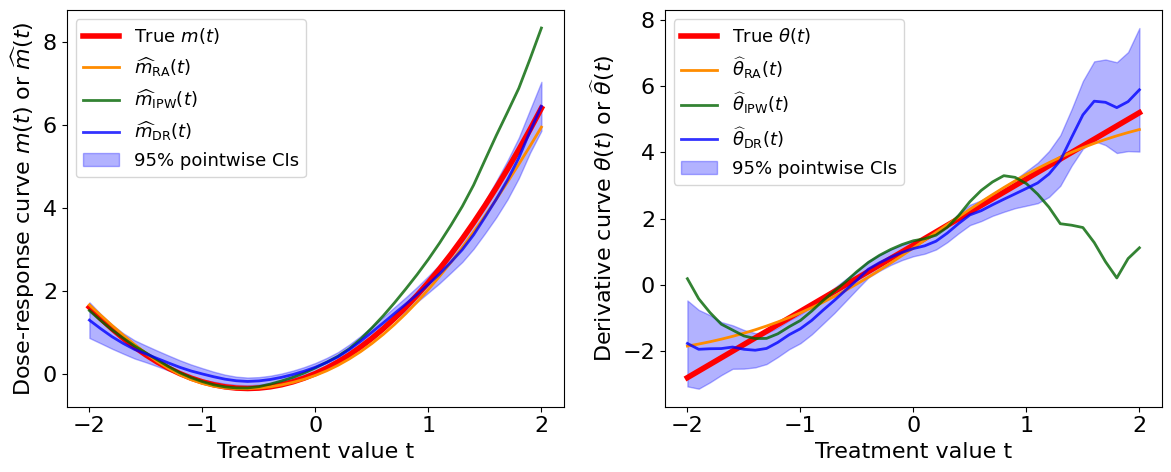

In [9]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(t_qry, 1.2*t_qry + t_qry**2, linewidth=4, color='red', label=r'True $m(t)$')
plt.plot(t_qry, m_est_ra5, linewidth=2, color='darkorange', label=r'$\widehat{m}_{\mathrm{RA}}(t)$')
plt.plot(t_qry, m_est_ipw5, linewidth=2, alpha=0.8, color='darkgreen', label=r'$\widehat{m}_{\mathrm{IPW}}(t)$')
plt.plot(t_qry, m_est_dr5, linewidth=2, alpha=0.8, color='blue', label=r'$\widehat{m}_{\mathrm{DR}}(t)$')
plt.fill_between(t_qry, m_est_dr5 - sd_est_dr5*scipy.stats.norm.ppf(0.975), 
                 m_est_dr5 + sd_est_dr5*scipy.stats.norm.ppf(0.975), 
                 color='blue', alpha=.3, label='95% pointwise CIs')
plt.legend(fontsize=13)
plt.xlabel('Treatment value t')
plt.ylabel(r'Dose-response curve $m(t)$ or $\widehat{m}(t)$')

plt.subplot(1, 2, 2)
plt.plot(t_qry, 1.2 + 2*t_qry, linewidth=4, color='red', label=r'True $\theta(t)$')
plt.plot(t_qry, theta_ra5, linewidth=2, color='darkorange', label=r'$\widehat{\theta}_{\mathrm{RA}}(t)$')
plt.plot(t_qry, theta_ipw5, linewidth=2, alpha=0.8, color='darkgreen', label=r'$\widehat{\theta}_{\mathrm{IPW}}(t)$')
plt.plot(t_qry, theta_dr5, linewidth=2, alpha=0.8, color='blue', label=r'$\widehat{\theta}_{\mathrm{DR}}(t)$')
plt.fill_between(t_qry, theta_dr5 - theta_sd5*scipy.stats.norm.ppf(0.975), 
                 theta_dr5 + theta_sd5*scipy.stats.norm.ppf(0.975), 
                 color='blue', alpha=.3, label='95% pointwise CIs')
plt.legend(fontsize=13)
plt.xlabel('Treatment value t')
plt.ylabel(r'Derivative curve $\theta(t)$ or $\widehat{\theta}(t)$')

plt.tight_layout()
plt.show()

## Example 4: RA, IPW, DR Estimations of Dose-Response Curve Derivative Without Positivity

We generate i.i.d. data $\{(Y_i, T_i,S_i)\}_{i=1}^n$ with $n=2000$ from the following data-generating model
\begin{align*}
	&Y=T^3 +T^2 + 10S+\epsilon, \quad T= \sin(\pi S) + E, \quad S\sim \mathrm{Uniform}[-1,1] \subset \mathbb{R}, 
\end{align*}
where $E\sim \mathrm{Uniform}[-0.3,0.3]$ is an independent treatment variation and $\epsilon\sim \mathcal{N}(0,1)$ is an independent noise variable. The marginal supports of $T$ and $S$ are $\mathcal{T}=[-1.3, 1.3]$ and $\mathcal{S}=[-1,1]$ respectively, while the joint support of $(T,S)$ only covers a thin band region of the product space $\mathcal{T}\times \mathcal{S}$. The true derivative effect curve is thus given by $\theta(t)=3t^2 + 2t$.

In [10]:
n = 2000

np.random.seed(123)
# Data generating process
X_sim = 2*np.random.rand(n) - 1
T_sim = np.sin(np.pi*X_sim) + np.random.rand(n)*0.6 - 0.3
Y_sim = T_sim**2 + T_sim**3 + 10*X_sim + np.random.normal(loc=0, scale=1, size=n)
X_dat = np.concatenate([T_sim.reshape(-1,1), X_sim.reshape(-1,1)], axis=1)

# Query points 
t_qry = np.linspace(-0.8, 0.8, 41)

# Choice of the bandwidth parameter
h = 2*np.std(T_sim)*n**(-1/5)

In [ ]:
# Bias-corrected RA estimator of \theta(t)
theta_C_RA5 = RADRDerivBC(Y=Y_sim, X=X_dat, t_eval=t_qry, mu=NeurNet, L=5, 
                          n_iter=1000, lr=0.01, h_bar=None, kernT_bar="gaussian")

In [ ]:
# Bias-corrected IPW estimator of \theta(t)
theta_C_IPW5, condTS5 = IPWDRDerivBC(Y=Y_sim, X=X_dat, t_eval=t_qry, L=5, h=h, kern='epanechnikov', 
                                     b=None, self_norm=True, thres_val=0.85)

In [ ]:
# Bias-corrected DR estimator of \theta(t)
theta_C_DR5, theta_C_sd5 = DRDRDerivBC(Y=Y_sim, X=X_dat, t_eval=t_qry, mu=NeurNet, L=5, h=h, kern='epanechnikov', 
                                       n_iter=1000, lr=0.01, b=None, thres_val=0.85, self_norm=False)

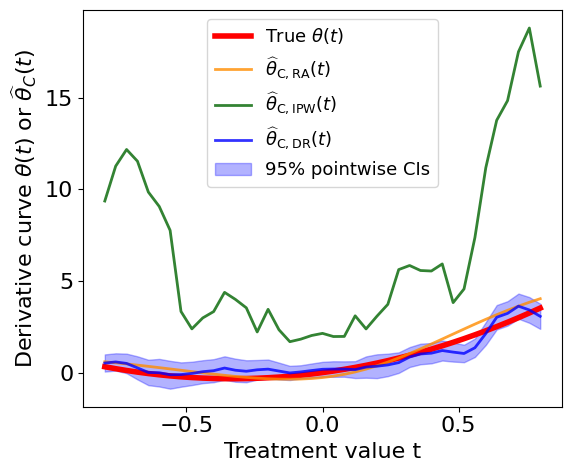

In [14]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(6,5))
plt.plot(t_qry, 2*t_qry + 3*(t_qry**2), linewidth=4, color='red', label=r'True $\theta(t)$')
plt.plot(t_qry, theta_C_RA5, linewidth=2, alpha=0.8, color='darkorange', label=r'$\widehat{\theta}_{\mathrm{C,RA}}(t)$')
plt.plot(t_qry, theta_C_IPW5, linewidth=2, alpha=0.8, color='darkgreen', label=r'$\widehat{\theta}_{\mathrm{C,IPW}}(t)$')
plt.plot(t_qry, theta_C_DR5, linewidth=2, alpha=0.8, color='blue', label=r'$\widehat{\theta}_{\mathrm{C,DR}}(t)$')
plt.fill_between(t_qry, theta_C_DR5 - theta_C_sd5*scipy.stats.norm.ppf(0.975), 
                 theta_C_DR5 + theta_C_sd5*scipy.stats.norm.ppf(0.975), 
                 color='blue', alpha=.3, label='95% pointwise CIs')
plt.legend(fontsize=13)
plt.xlabel('Treatment value t')
plt.ylabel(r'Derivative curve $\theta(t)$ or $\widehat{\theta}_C(t)$')
plt.tight_layout()
plt.show()